In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForTokenClassification
from transformers import pipeline
import torch

In [15]:
# Load dataset
df = pd.read_csv('NER_Dataset.csv')
df.head()


,Sentence_ID,Word,POS,Tag
0,Sentence: 1,"['Thousands', 'of', 'demonstrators', 'have', '...","['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 10,"['Iranian', 'officials', 'say', 'they', 'expec...","['JJ', 'NNS', 'VBP', 'PRP', 'VBP', 'TO', 'VB',...","['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '..."
2,Sentence: 100,"['Helicopter', 'gunships', 'Saturday', 'pounde...","['NN', 'NNS', 'NNP', 'VBD', 'JJ', 'NNS', 'IN',...","['O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', '..."
3,Sentence: 1000,"['They', 'left', 'after', 'a', 'tense', 'hour-...","['PRP', 'VBD', 'IN', 'DT', 'NN', 'JJ', 'NN', '...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 10000,"['U.N.', 'relief', 'coordinator', 'Jan', 'Egel...","['NNP', 'NN', 'NN', 'NNP', 'NNP', 'VBD', 'NNP'...","['B-geo', 'O', 'O', 'B-per', 'I-per', 'O', 'B-..."


In [16]:
# Convert the text column into sentences
def convert_to_sentences(df):
    sentences = []
    labels = []
    for sentence_id, group in df.groupby("Sentence_ID"):
        sentences.append(" ".join(group["Word"].values))
        labels.append(" ".join(group["Tag"].values))
    return sentences, labels

sentences, labels = convert_to_sentences(df)

# Convert the labels into the BIO format
def preprocess_labels(labels):
    return [label.split() for label in labels]

labels = preprocess_labels(labels)

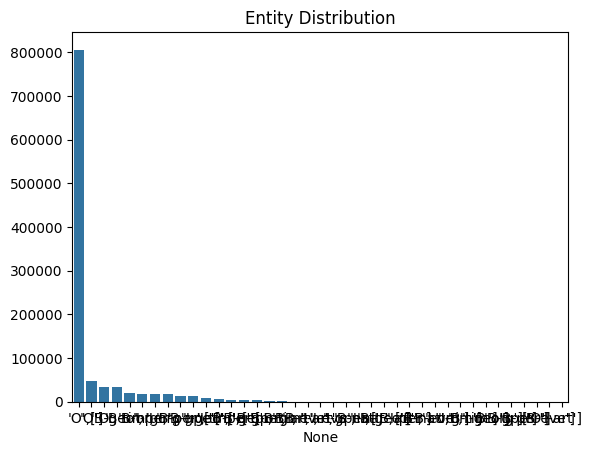

In [17]:
# Plot the distribution of entities
all_labels = [label for sublist in labels for label in sublist]
entity_counts = pd.Series(all_labels).value_counts()
sns.barplot(x=entity_counts.index, y=entity_counts.values)
plt.title('Entity Distribution')
plt.show()


In [18]:
import random
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding

In [19]:
# Load SpaCy model
nlp = spacy.blank("en")


In [20]:
# Define a blank pipeline for NER
if "ner" not in nlp.pipe_names:
    ner = nlp.create_pipe("ner")
    nlp.add_pipe("ner")

In [21]:
# Add labels to the NER pipeline
for label in set(all_labels):
    ner.add_label(label)

In [22]:
# Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(sentences, labels, test_size=0.2, random_state=42)

In [23]:
# Convert the data into SpaCy's required format
def convert_to_spacy_format(texts, labels):
    data = []
    for text, label in zip(texts, labels):
        entities = []
        start = 0
        for word, tag in zip(text.split(), label):
            end = start + len(word)
            if tag != "O":
                entities.append((start, end, tag))
            start = end + 1
        data.append((text, {"entities": entities}))
    return data

train_data = convert_to_spacy_format(train_texts, train_labels)
test_data = convert_to_spacy_format(test_texts, test_labels)

In [ ]:
# Train the SpaCy model (using minibatches for efficiency)
def train_spacy_ner(model, train_data, iterations=7):
    optimizer = model.begin_training()
    for i in range(iterations):
        random.shuffle(train_data)
        losses = {}
        batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.5))
        for batch in batches:
            texts, annotations = zip(*batch)
            examples = [Example.from_dict(model.make_doc(text), ann) for text, ann in zip(texts, annotations)]
            model.update(examples, drop=0.5, losses=losses)
        print(f"Iteration {i + 1}: Losses {losses}")
    return model

nlp = train_spacy_ner(nlp, train_data)

Iteration 1: Losses {'ner': 414376.60520709}
Iteration 2: Losses {'ner': 273943.3728745454}
Iteration 3: Losses {'ner': 200623.35839453147}
Iteration 4: Losses {'ner': 151877.63533156377}
Iteration 5: Losses {'ner': 130875.32245768665}
Iteration 6: Losses {'ner': 123046.19794846007}
Iteration 7: Losses {'ner': 116338.76992940519}


In [25]:
# Predict and evaluate
def evaluate_spacy_ner(model, texts, true_entities):
    pred_entities = []
    for text in texts:
        doc = model(text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]
        pred_entities.append(entities)
    # Calculate and print evaluation metrics
    return pred_entities

pred_entities = evaluate_spacy_ner(nlp, test_texts, test_labels)

In [28]:
from sklearn.metrics import classification_report

from sklearn.metrics import classification_report

# Function to align predicted and true labels
def align_labels(true_entities, pred_entities):
    aligned_true_labels = []
    aligned_pred_labels = []

    for true_label_list, pred_label_list in zip(true_entities, pred_entities):
        true_index = 0
        pred_index = 0
        while true_index < len(true_label_list) and pred_index < len(pred_label_list):
            true_label = true_label_list[true_index]
            pred_label = pred_label_list[pred_index]

            aligned_true_labels.append(true_label)
            aligned_pred_labels.append(pred_label)

            true_index += 1
            pred_index += 1

    return aligned_true_labels, aligned_pred_labels

# Prepare true and predicted labels for evaluation
true_labels_flat = [label for sublist in test_labels for label in sublist]
pred_labels_flat = [ent[1] for sublist in pred_entities for ent in sublist]

# Align the labels
aligned_true_labels, aligned_pred_labels = align_labels(true_labels_flat, pred_labels_flat)

# Evaluate the model using classification report
print(classification_report(aligned_true_labels, aligned_pred_labels))


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           '       0.89      0.89      0.89    401168
           ,       0.88      0.88      0.88    176284
           -       0.41      0.40      0.41     32240
           B       0.21      0.21      0.21     22532
           I       0.38      0.36      0.37      9708
           O       0.84      0.84      0.84    177590
           [       0.20      0.20      0.20      9592
           ]       0.20      0.20      0.20      9583
           a       0.00      0.00      0.00       188
           e       0.69      0.76      0.72      8615
           g       0.33      0.34      0.34     14994
           i       0.97      0.72      0.82      1811
           m       0.97      0.80      0.88      1624
           n       0.00      0.00      0.00        52
           o       0.41      0.43      0.42      9978
           p       0.42      0.51      0.46      7154
           r       0.69      0.57      0.63      8822
           t       0.34    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
